# Nonlinear Regression


## Learning Objectives

After studying this notebook, attending class, asking questions, and reviewing your notes, you should be able to:
* Perform residual analysis for nonlinear regression (as a diagnostic plot)
* Calculate standard errors (i.e., standard deviation) of the residuals
* Calculate nonlinear regression best fit using Python
* Assemble the covariance matrix for nonlinear regression

In [1]:
# load libraries
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt

## Main Idea

Solve the best fit optimization problem,

$$\min_{\hat{\theta}} \quad \sum (y_i - \hat{y}_i)^2$$

computationally. This works even if $\hat{y_i} = f(\hat{\theta}, x_i)$ is a nonlinear function.

Recall $\theta$ = [$V_{max}$, $K_m$] for our example from [this notebook.](../15/Transformations-and-Linear-Regression.ipynb)


## Step 1: Calculate and Plot Best Fit

The good news is that `scipy` has a fairly robust function for nonlinear regression. We will start by defining our own function for the model:

In [2]:
## define function that includes nonlinear model
def model(theta,x):
    '''
    Michaelis-Menten model
    Arguments:
        theta: parameter vector
        x: independent variable vector (S concentration)
    Returns:
        yhat: dependent variable prediction (r rate)
    '''
    yhat = (theta[0] * x) / (theta[1] + x) 
    return yhat

But `scipy` actually wants a function that takes three inputs and returns the residual vector. We will call our function `model` in this new function.

In [3]:
def regression_func(theta, x, y):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        theta: parameter vector
        x: independent variable vector
        y: dependent variable vector (measurements)
    Returns:
        e: residual vector
    '''
    e = y - model(theta,x);
    
    return e

Now we can define an initial guess and call the least squares optimizer.

In [4]:
## experimental data (generated and discussed in the previous notebook)
Vmaxexact=2
Kmexact=5
Sexp = np.array([.3, .4, 0.5, 1, 2, 4, 8, 16])
rexp = Vmaxexact*Sexp / (Kmexact+Sexp);
rexp += 0.05*np.random.normal(size=len(Sexp)) # add random noise to simulate observation errors 
rexp = np.array([0.10679829, 0.12073291, 0.23813671, 0.37799815, 0.58318205, 0.9434036, 1.20844411, 1.53945006])

## specify initial guess
theta0 = np.array([1.0, 5.0])

## specify bounds
# first array: lower bounds
# second array: upper bounds
bnds = ([0.0, 0.0], [np.inf, np.inf])

## use least squares optimizer in scipy
# argument 1: function that takes theta as input, returns residual
# argument 2: initial guess for theta
# optional arguments 'bounds': bounds for theta
# optional arugment 'args': additional arguments to pass to residual function
# optional argument 'method': select the numerical method
#   if you want to consider bounds, choose 'trf'
#   if you do not want to consider bounds, try either 'lm' or 'trf'
nl_results = optimize.least_squares(regression_func, theta0,bounds=bnds, method='trf',args=(Sexp, rexp))

theta = nl_results.x
print("theta = ",theta)

theta =  [1.94625917 4.47747018]


Interesting, we got a different answer than with transformations & linear regression. Let's revist that in a minute. We can plot of nonlinear best fit model.

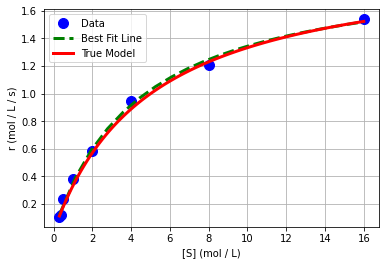

In [5]:
# add true data (from previous notebook)
S = np.linspace(np.min(Sexp),np.max(Sexp),100)
r = Vmaxexact*S / (Kmexact+S)

# generate predictions
S_pred = np.linspace(np.min(Sexp),np.max(Sexp),20)
r_pred = model(theta, S_pred)

# create plot
plt.plot(Sexp,rexp,'.b',markersize=20,label='Data')
plt.plot(S_pred,r_pred,'--g',linewidth=3,label='Best Fit Line')
plt.plot(S,r,'r-',linewidth=3,label='True Model')
plt.xlabel('[S] (mol / L)')
plt.ylabel('r (mol / L / s)')
plt.grid(True)
plt.legend()
plt.show()

We see that it looks a lot better.

## Step 2: Residual Analysis

In [6]:
## calculate residuals
y_hat2 = model(theta,Sexp)
e2 = rexp - y_hat2
print(e2)

[-0.01541655 -0.03887927  0.04262985  0.02267733 -0.01774983  0.02508286
 -0.03941088  0.01874723]


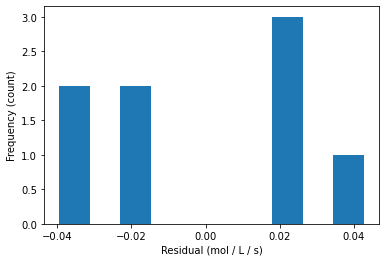

In [7]:
plt.hist(e2)
plt.xlabel("Residual (mol / L / s)")
plt.ylabel("Frequency (count)")
plt.show()

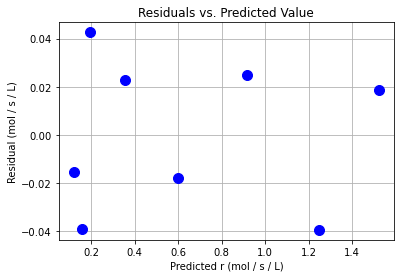

In [8]:
plt.plot(y_hat2,e2,"b.",markersize=20)
plt.xlabel("Predicted r (mol / s / L)")
plt.ylabel("Residual (mol / s / L)")
plt.grid(True)
plt.title("Residuals vs. Predicted Value")
plt.show()

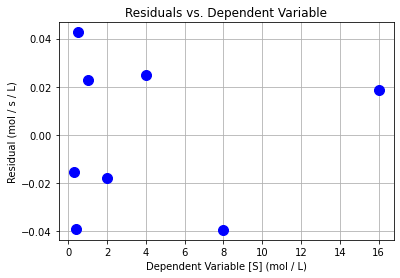

In [9]:
plt.plot(Sexp,e2,"b.",markersize=20)
plt.xlabel("Dependent Variable [S] (mol / L)")
plt.ylabel("Residual (mol / s / L)")
plt.grid(True)
plt.title("Residuals vs. Dependent Variable")
plt.show()

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Do the residuals pass the diagnostic tests? Discuss with your neighbor.
</div>

## Step 3: Uncertainty Analysis

$$
\Sigma_{\theta} \approx \hat{\sigma}_e^2 (J^T J)^{-1}
$$

where $J$ is the Jacobian of the residuals w.r.t. $\theta$:

$$
J_{i,j} = \frac{\partial(y_i - \hat{y}_i)}{\partial \theta_j}
$$

Fortunately, `scipy` approximates this Jacobian for us.

In [10]:
print("Jacobian =\n")
print(nl_results.jac)

Jacobian =

[[-0.06279474  0.0255815 ]
 [-0.08200973  0.03272438]
 [-0.10045264  0.03927836]
 [-0.18256603  0.06486951]
 [-0.30876252  0.09277262]
 [-0.47183888  0.10832486]
 [-0.64115561  0.10000865]
 [-0.78134652  0.07426224]]


Notice this is NOT the same Jacobian used for error propagation in this [previous notebook.](../15/Transformations-and-Linear-Regression.ipynb)

In [11]:
sigre = (e2.T @ e2)/(len(e2) - 2)
Sigma_theta2 = sigre * np.linalg.inv(nl_results.jac.T @ nl_results.jac)
print("Covariance matrix:\n",Sigma_theta2)

Covariance matrix:
 [[0.00450233 0.02306357]
 [0.02306357 0.14479753]]
